##  ROSSMANN DATA SCIENCE PROJECT

### Introduction:
This is a Data Science project to train my skills as a data scientist. It uses sales data  from the german drug store chain [Rossman](https://de.wikipedia.org/wiki/Rossmann) which can be found in [kaggle](https://www.kaggle.com/c/rossmann-store-sales/data). The data was originally made public in a Kaggle contest to train a machine learning model that would predict as accurately as possible the next 6 weeks' sales by store. In my case, the following fictitious business problem was created to simulate the kind of tasks that a data scientist could have to perform in a working environment:  

Currently, Rossmann store managers are tasked with preparing their weekly sales forecasts up to eight weeks in advance. Store sales results are influenced by many factors, including promotions, competitive intensity, school and national vacations, seasonal changes and location condition.  

- Because thousands of individual store managers create sales forecasts based on their individual circumstances, the accuracy of the results can vary widely. Therefore, the company's data science team is on a new mission to create a unified modeling methodology for store managers to predict weekly results with greater accuracy.  

- The management team also needs an overall report with feasible or actionable strategie to understand the overall performance of all stores and find a way to optimize future sales performance (i.e. revenue).  

- Finally, an individual store performance report needs to be provided to each store manager.

For this project we use a dataset named `train.csv` which contains historical sales data for 1,115 Rossmann stores from 2013-01-01 to 2015-07-31 (YY-MM-DD). We will also make use of supplemental information about the stores contained in a file named `store.csv`. I've organized the prject in serveral Notebook names follow the format “[number-prefix]_[description]”. It is recommended to explore the notebooks following the order given by the number prefix.

notebooks. In this first notebook we will familiarize ourselves with the data from the `train.csv` and run EDA (Explorative Data Analysis) based on this data.

#### Import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_palette("Set2")
warnings.filterwarnings("ignore")
%matplotlib inline

#### Reading and customizing sales data

In [2]:
# I specify the dtype of StateHoliday as object because it is originally a mixture of numbers and strings
sales_df = pd.read_csv("../data/train.csv", dtype={'StateHoliday': 'object'}, parse_dates=['Date'])
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


The meanings of the variables are as follows:
- Store: A unique ID for each store. Takes consecutive values from 1 to 1115.
- DayOfWeek: Self-explanatory. Coded as Monday -> 1, Tuesday -> 2,...,Sunday -> 7.
- Date: Self-explanatory. The format is YYYY-MM-DD 
- Sales: The sales for a given day in Euros (this is the target variable to be predicted, after being aggregated on a weekly level).
- Customers: The number of customers on a given day.
- Open: An indicator of whether the store (branch) was open (0 = closed, 1 = open).
- StateHoliday: Indicates a state holiday. (a = public holiday, b = Easter vacation, c = Christmas, 0 = no holiday).
- SchoolHoliday: Indicates whether the (branch, date) pair was affected by the closure of public schools (0 = not affected, 1 = affected).

#### Exploratory data analysis

As we have a time-series for each of the stores, we are dealing with what in the literature is kown as "Panel Data". First of all, how many observations do we have?

In [4]:
no_days = (sales_df['Date'].max() - sales_df['Date'].min()).days +1
print("The data spans {} days.". format(no_days))

The data spans 942 days.


With 1115 stores and 942 days, it should result in a total of 1115x942=1,050,330 data points and we only have 1,017,209 rows in this data set. Ideally, we should have information on all 1115 stores every day, but this is not the case.

In [5]:
# Create a time series for the number of observations per day
obs_by_date = sales_df.groupby('Date').size()

total_days = 0
for obs in obs_by_date.unique():
    obs_size = obs_by_date[obs_by_date == obs].size
    total_days += obs_size
    print("There are {} Day(s) with {} Datapoints.".format(obs_size, obs))

There are 1 Day(s) with 1114 Datapoints.
There are 757 Day(s) with 1115 Datapoints.
There are 184 Day(s) with 935 Datapoints.


In [6]:
print("Number of closed stores with a turnover of more than zero: {}".format(len(sales_df[(sales_df['Sales'] > 0) & (sales_df['Open'] == 0)])))

Number of closed stores with a turnover of more than zero: 0


But there are stores that were open and didn't sell anything:

In [7]:
sales_df[(sales_df['Sales'] == 0) & (sales_df['Open'] == 1)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
86825,971,5,2015-05-15,0,0,1,0,0,1
142278,674,4,2015-03-26,0,0,1,0,0,0
196938,699,4,2015-02-05,0,0,1,1,0,0
322053,708,3,2014-10-01,0,0,1,1,0,0
330176,357,1,2014-09-22,0,0,1,0,0,0
340348,227,4,2014-09-11,0,0,1,0,0,0
340860,835,4,2014-09-11,0,0,1,0,0,0
341795,835,3,2014-09-10,0,0,1,0,0,0
346232,548,5,2014-09-05,0,0,1,1,0,1
346734,28,4,2014-09-04,0,0,1,1,0,0


Due to the penultimate finding, we will limit our analysis to the points at which the store in question was open. Let's first take a look at the descriptive statistics:

In [8]:
sales_open_df = sales_df[sales_df['Open'] == 1]
pd.options.display.float_format = "{:,.2f}".format
sales_open_df.drop('Store', axis=1).describe()

,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
count,"844,392.00",844392,"844,392.00","844,392.00","844,392.00","844,392.00","844,392.00"
mean,3.52,2014-04-11 01:02:42.487565056,"6,955.51",762.73,1.00,0.45,0.19
min,1.00,2013-01-01 00:00:00,0.00,0.00,1.00,0.00,0.00
25%,2.00,2013-08-16 00:00:00,"4,859.00",519.00,1.00,0.00,0.00
50%,3.00,2014-03-31 00:00:00,"6,369.00",676.00,1.00,0.00,0.00
75%,5.00,2014-12-10 00:00:00,"8,360.00",893.00,1.00,1.00,0.00
max,7.00,2015-07-31 00:00:00,"41,551.00","7,388.00",1.00,1.00,1.00
std,1.72,NaN,"3,104.21",401.23,0.00,0.50,0.40


We can see that there are data points where profits and customer numbers are well above average.

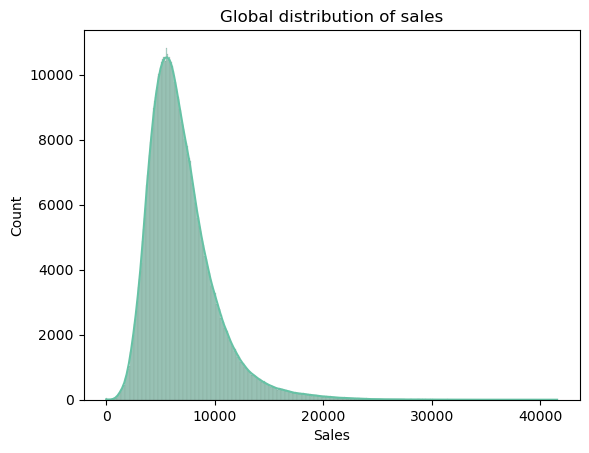

In [9]:
sns.histplot(sales_open_df['Sales'], kde=True).set(title="Global distribution of sales");

In [10]:
sales_mean = sales_open_df['Sales'].mean()
sales_std = sales_open_df['Sales'].std()
high_sales = sales_mean + 3*sales_std
sales_high_df = sales_open_df[sales_open_df['Sales'] > high_sales]

print("Average turnover: {:.2f} Euros".format(sales_mean))
print("Standard Deviation: {:.2f} Euros".format(sales_std))
print("Number of data points with sales more than three standard deviations above the average \n(>{:.2f} Euros): {}"
      .format(high_sales, len(sales_high_df)))

Average turnover: 6955.51 Euros
Standard Deviation: 3104.21 Euros
Number of data points with sales more than three standard deviations above the average 
(>16268.16 Euros): 13437


In [11]:
sales_outlier_stores = pd.DataFrame(sales_high_df.groupby('Store').size().sort_values(ascending=False)
                              .rename("NoDaysWithVeryHighSales"))
sales_outlier_stores[:10]

,NoDaysWithVeryHighSales
Store,
262,842
1114,734
562,684
817,667
251,614
513,544
788,512
383,488
842,449


We can see that there are stores that (very) often achieve sales well above the average. This may well have to do with the general (perhaps even external) conditions of the stores in question.

So what is the relationship between customer numbers and sales?

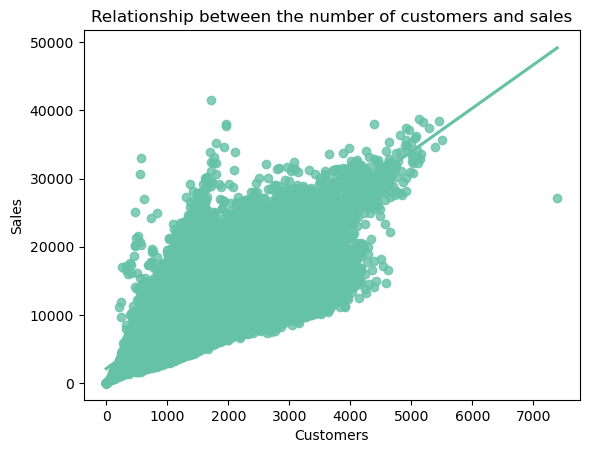

In [12]:
sns.regplot(x='Customers', y='Sales', data=sales_open_df).set(title="Relationship between the number of customers and sales");

As expected, there is a positive correlation between these two variables.  
What does the distribution of `Customers` look like?

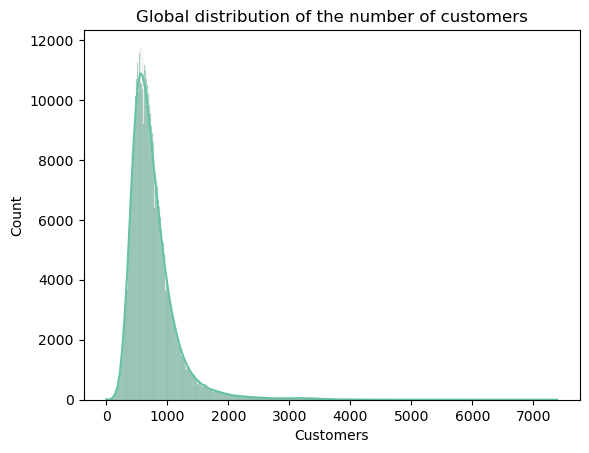

In [13]:
sns.histplot(sales_open_df['Customers'], kde=True).set(title="Global distribution of the number of customers");

The distribution of the number of customers has a similar shape to the distribution of sales. Intuitively, I would think that stores with a very high number of customers are also generally those with very high sales.

In [14]:
customers_mean = sales_open_df['Customers'].mean()
customers_std = sales_open_df['Customers'].std()
high_customers = customers_mean + 3*customers_std
customers_high_df = sales_open_df[sales_open_df['Customers'] > high_customers]

print("Average number of customers: {:.2f}".format(customers_mean))
print("Standard Deviation: {:.2f}".format(customers_std))
print("Number of data points with number of customers more than three standard deviations above the average \n(>{:.2f}): {}"
      .format(high_customers, len(customers_high_df)))

Average number of customers: 762.73
Standard Deviation: 401.23
Number of data points with number of customers more than three standard deviations above the average 
(>1966.41): 15519


In [15]:
customers_outlier_stores = pd.DataFrame(customers_high_df.groupby('Store').size().sort_values(ascending=False)
                              .rename("NoDaysWithVeryHighNumberOfCustomers"))
customers_outlier_stores[:10]

,NoDaysWithVeryHighNumberOfCustomers
Store,
262,942
562,937
733,937
769,931
1097,844
259,791
1114,780
817,765
251,765


In [16]:
print("Number of stores that achieved very high sales: {}".format(len(sales_outlier_stores.index)))
print("Number of stores that had a very large number of potential customers: {}".format(len(customers_outlier_stores.index)))
print("Number of stores in both categories: {}".format(len(sales_outlier_stores.index.intersection(customers_outlier_stores.index))))

Number of stores that achieved very high sales: 409
Number of stores that had a very large number of potential customers: 133
Number of stores in both categories: 123


##### Global time series behavior for sales and number of customers

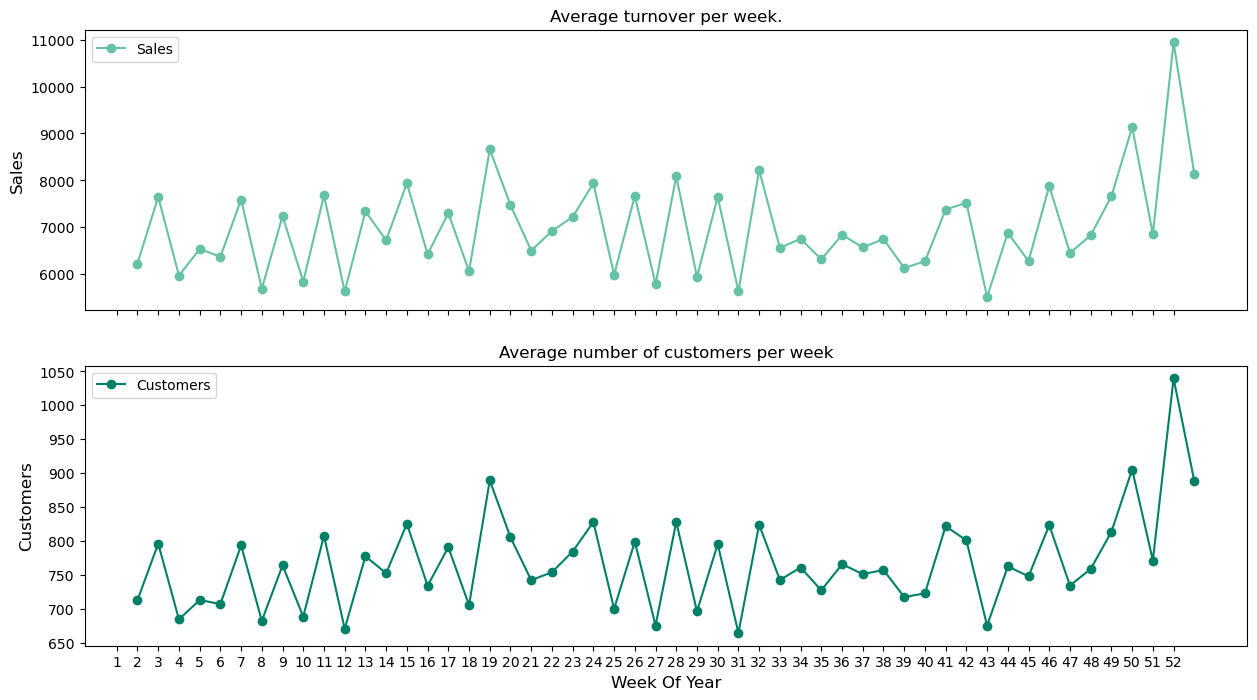

In [17]:
fig, axes = plt.subplots(2,1,sharex=True,figsize=(15,8))

# Create a WeekOfYear column and generate weekly time series for sales and customers
sales_open_df['WeekOfYear'] = sales_open_df['Date'].dt.isocalendar().week
average_week_sales = sales_open_df.groupby('WeekOfYear')["Sales"].mean()
average_week_customers = sales_open_df.groupby('WeekOfYear')["Customers"].mean()

# plot these time series
ax1 = average_week_sales.plot(legend=True, ax=axes[0], marker='o', title="Average turnover per week.")
ax1.set_xticks(range(len(average_week_sales)))
ax1.set_xticklabels(average_week_sales.index.tolist())
ax1.set_ylabel('Sales', size=12)

ax2 = average_week_customers.plot(legend=True, ax=axes[1], marker='o', colormap="summer", title="Average number of customers per week")
ax2.set_ylabel('Customers', size=12)

plt.xlabel('Week Of Year', size=12);

We note that both time series develop very similarly, with pronounced peaks at the end of the year.  
Let's now see how the global average of the turnover develops over the recorded years:

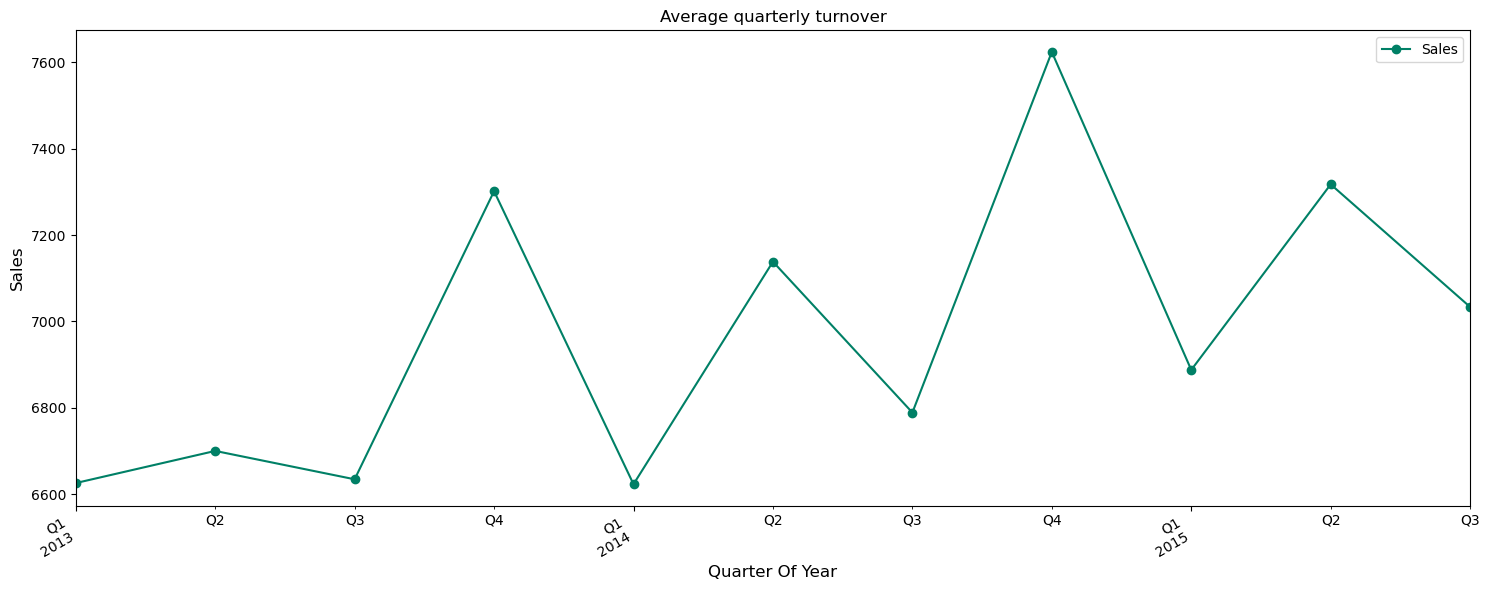

In [18]:
fig, ax = plt.subplots(figsize=(15,6))

sales_open_df['Quarter'] = pd.PeriodIndex(sales_open_df['Date'], freq='Q')
average_qt_sales = sales_open_df.groupby('Quarter')["Sales"].mean()

ax = average_qt_sales.plot(legend=True, marker='o', title="Average quarterly turnover", colormap="summer")
ax.set_ylabel('Sales', size=12)

plt.xlabel('Quarter Of Year', size=12)
fig.autofmt_xdate()
plt.tight_layout();

There seems to be a general upward trend in the turnover.

##### DayOfWeek

In [19]:
by_weekday = sales_open_df.groupby('DayOfWeek')[['Customers', 'Sales']].mean()\
.rename({'Customers': 'CustomersMean', 'Sales': 'SalesMean'}, axis=1)
by_weekday['SalesPerCustomer'] = by_weekday['SalesMean'] / by_weekday['CustomersMean']
by_weekday

,CustomersMean,SalesMean,SalesPerCustomer
DayOfWeek,,,
1,855.44,"8,216.07",9.60
2,769.99,"7,088.11",9.21
3,740.60,"6,728.12",9.08
4,755.57,"6,767.31",8.96
5,781.77,"7,072.68",9.05
6,660.18,"5,874.84",8.90
7,"1,441.53","8,224.72",5.71


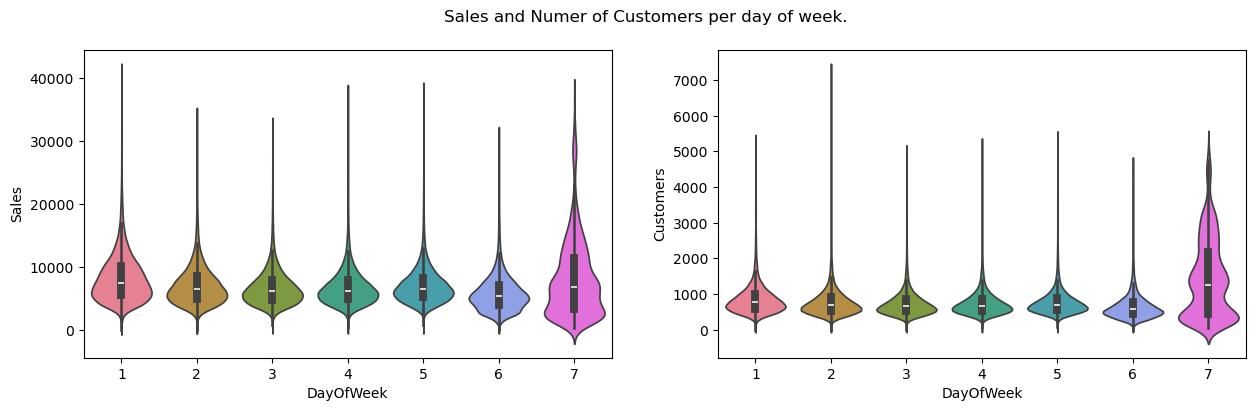

In [20]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.violinplot(x='DayOfWeek', y='Sales', data=sales_open_df, palette='husl', order=[1,2,3,4,5,6,7], ax=axis1)
sns.violinplot(x='DayOfWeek', y='Customers', data=sales_open_df, palette='husl', order=[1,2,3,4,5,6,7], ax=axis2)
plt.suptitle("Sales and Numer of Customers per day of week.");

Stores open on Sundays have many customers and make high profits, but the ratio of customers to sales is relatively low. After Sundays, Mondays are the most profitable days.

##### Promo

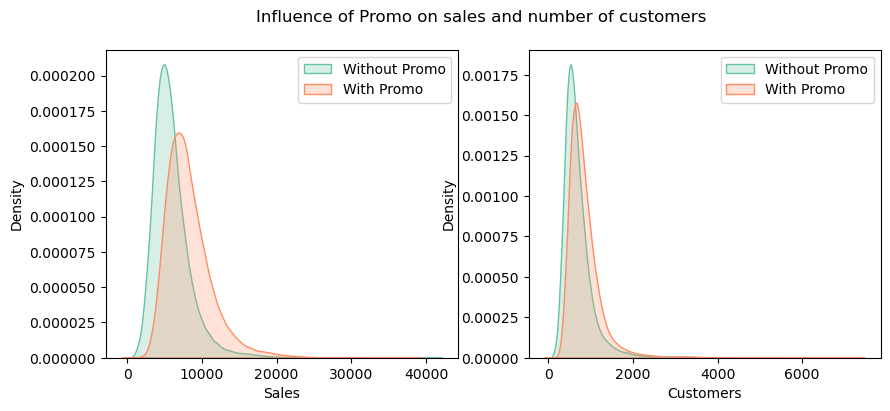

In [21]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.kdeplot(x = sales_open_df['Sales'][sales_open_df['Promo'] == 0], shade = True)
sns.kdeplot(x = sales_open_df['Sales'][sales_open_df['Promo'] == 1], shade = True)
plt.legend(labels = ['Without Promo', 'With Promo'], loc = 'upper right')

plt.subplot(1, 2, 2)
sns.kdeplot(x = sales_open_df['Customers'][sales_open_df['Promo'] == 0], shade = True)
sns.kdeplot(x = sales_open_df['Customers'][sales_open_df['Promo'] == 1], shade = True)
plt.legend(labels = ['Without Promo', 'With Promo'], loc = 'upper right')

plt.suptitle("Influence of Promo on sales and number of customers");

In [22]:
sales_open_df.groupby('Promo')[['Customers', 'Sales']].describe(percentiles=[.5]).transpose()

Promo                    0          1
Customers count 467,496.00 376,896.00
          mean      696.86     844.43
          std       388.91     401.24
          min         0.00       0.00
          50%       610.00     757.00
          max     5,387.00   7,388.00
Sales     count 467,496.00 376,896.00
          mean    5,929.41   8,228.28
          std     2,629.65   3,175.76
          min         0.00       0.00
          50%     5,459.00   7,649.00
          max    41,551.00  38,722.00

An active promotion has a positive impact on the numer of customers and sales.

##### Relation between the different types of public holidays and sales/customers

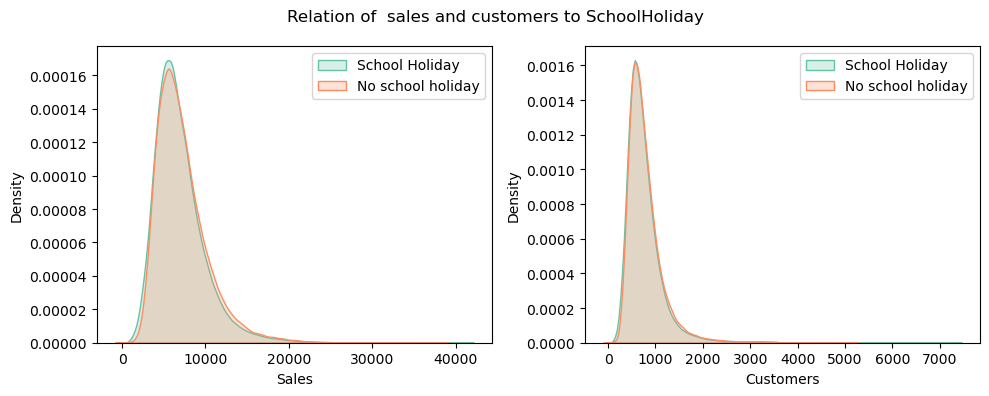

In [23]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.kdeplot(x = sales_open_df['Sales'][sales_open_df['SchoolHoliday'] == 0], shade = True)
sns.kdeplot(x = sales_open_df['Sales'][sales_open_df['SchoolHoliday'] == 1], shade = True)
plt.legend(labels = ['School Holiday', 'No school holiday'], loc = 'upper right')

plt.subplot(1, 2, 2)
sns.kdeplot(x = sales_open_df['Customers'][sales_open_df['SchoolHoliday'] == 0], shade = True)
sns.kdeplot(x = sales_open_df['Customers'][sales_open_df['SchoolHoliday'] == 1], shade = True)
plt.legend(labels = ['School Holiday', 'No school holiday'], loc = 'upper right')

plt.suptitle("Relation of  sales and customers to SchoolHoliday")
plt.tight_layout();

In [24]:
sales_open_df.groupby('SchoolHoliday')[['Customers', 'Sales']].describe(percentiles=[.5]).transpose()

SchoolHoliday            0          1
Customers count 680,935.00 163,457.00
          mean      757.83     783.12
          std       401.08     401.21
          min         0.00       0.00
          50%       672.00     691.00
          max     7,388.00   5,192.00
Sales     count 680,935.00 163,457.00
          mean    6,896.78   7,200.18
          std     3,083.77   3,176.30
          min         0.00       0.00
          50%     6,326.00   6,562.00
          max    41,551.00  38,367.00

In [25]:
sales_open_df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [26]:
dict_holiday = {'0': 'no_holiday', 'a': 'public_holiday', 'b': 'easter','c': 'christmas'}
sales_open_df['StateHoliday'] = sales_open_df['StateHoliday'].apply(lambda x: dict_holiday[x])

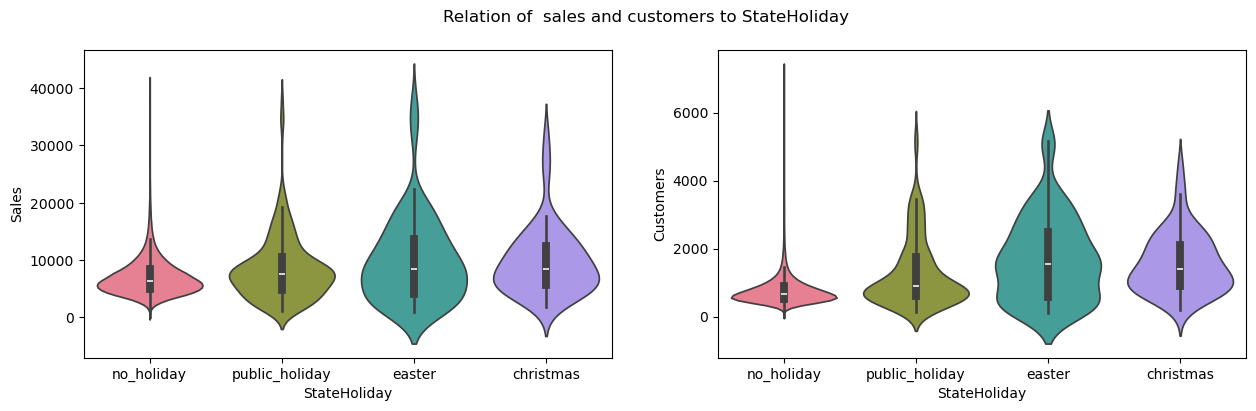

In [27]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.violinplot(x='StateHoliday', y='Sales', data=sales_open_df, order=sales_open_df['StateHoliday'].unique(), palette='husl', ax=axis1)
sns.violinplot(x='StateHoliday', y='Customers', data=sales_open_df, order=sales_open_df['StateHoliday'].unique(), palette='husl', ax=axis2)

plt.suptitle("Relation of  sales and customers to StateHoliday");

In [28]:
sales_open_df.groupby('StateHoliday')[['Customers', 'Sales']].describe(percentiles=[.5]).transpose()

StateHoliday     christmas    easter  no_holiday  public_holiday
Customers count      71.00    145.00  843,482.00          694.00
          mean    1,569.23  1,686.89      762.08        1,279.17
          std       884.91  1,234.62      399.45        1,018.37
          min       190.00    116.00        0.00          129.00
          50%     1,394.00  1,554.00      675.00          887.00
          max     4,468.00  5,152.00    7,388.00        5,494.00
Sales     count      71.00    145.00  843,482.00          694.00
          mean    9,743.75  9,887.89    6,953.52        8,487.47
          std     5,980.86  7,551.78    3,098.87        5,708.63
          min     1,800.00    960.00        0.00        1,010.00
          50%     8,397.00  8,423.00    6,368.00        7,556.00
          max    32,169.00 38,722.00   41,551.00       38,484.00

In [29]:
# Save this data to csv file for later use
sales_open_df.to_csv("../data/sales_open.csv", index=False)

There are generally more customers and sales during the state holidays, especially at Easter and Christmas. There also seems to be a little increment in the sales on school holidays, but in any case it doesn't seem too to be too significative.